<a href="https://colab.research.google.com/github/lisapuche/ProyectoFinal-VisionPorComputador/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final - Visión por Computador
## Lisa María Puche Padilla
### 19 de octubre de 2024

## Cargar datos

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import cv2
import shutil
from shutil import copy, copytree, rmtree
import matplotlib.pyplot as plt
import matplotlib.image as img
from collections import defaultdict
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten,
    Convolution2D, MaxPooling2D, ZeroPadding2D,
    GlobalAveragePooling2D, AveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###  Dataset Food-101

Para este proyecto, se utilizó el dataset Food-101. Este dataset contiene un total de 101,000 imágenes de comida, distribuidas en 101 categorías diferentes, con 1000 imágenes por cada clase.

El dataset Food-101 fue presentado en el artículo "Food-101 – Mining Discriminative Components with Random Forests" por Lukas Bossard, Matthieu Guillaumin y Luc Van Gool. Se trata de un conjunto de datos extenso y de alta calidad, ideal para evaluar técnicas de visión por computadora. Por lo tanto, algunas imágenes no fueron depuradas y contienen algún tipo de ruido. Además, todas las imágenes fueron reescaladas para tener un tamaño máximo de 512 pixeles.

El objetivo del análisis es la la **clasificación** de las imágenes de comida en sus respectivas categorías.


In [2]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

get_data_extract()

Dataset already exists


In [3]:
os.listdir('food-101/images')

['sushi',
 'ramen',
 'escargots',
 'samosa',
 'bibimbap',
 'deviled_eggs',
 'fried_rice',
 'donuts',
 'pizza',
 'hummus',
 'baklava',
 'ice_cream',
 'grilled_salmon',
 'gnocchi',
 'foie_gras',
 'filet_mignon',
 'grilled_cheese_sandwich',
 'pho',
 'prime_rib',
 'cannoli',
 'scallops',
 'guacamole',
 'apple_pie',
 'baby_back_ribs',
 'chocolate_mousse',
 'seaweed_salad',
 'steak',
 'beet_salad',
 'caesar_salad',
 'tiramisu',
 'ravioli',
 'tuna_tartare',
 'panna_cotta',
 'macaroni_and_cheese',
 'shrimp_and_grits',
 'tacos',
 'cheese_plate',
 'french_toast',
 'hot_and_sour_soup',
 'macarons',
 'spaghetti_bolognese',
 'fish_and_chips',
 'beef_carpaccio',
 'hot_dog',
 'chicken_quesadilla',
 'french_fries',
 'greek_salad',
 'french_onion_soup',
 'omelette',
 'strawberry_shortcake',
 'falafel',
 'carrot_cake',
 'clam_chowder',
 'onion_rings',
 'fried_calamari',
 'frozen_yogurt',
 'lobster_roll_sandwich',
 'crab_cakes',
 'hamburger',
 'beef_tartare',
 'oysters',
 'pork_chop',
 'breakfast_burrito

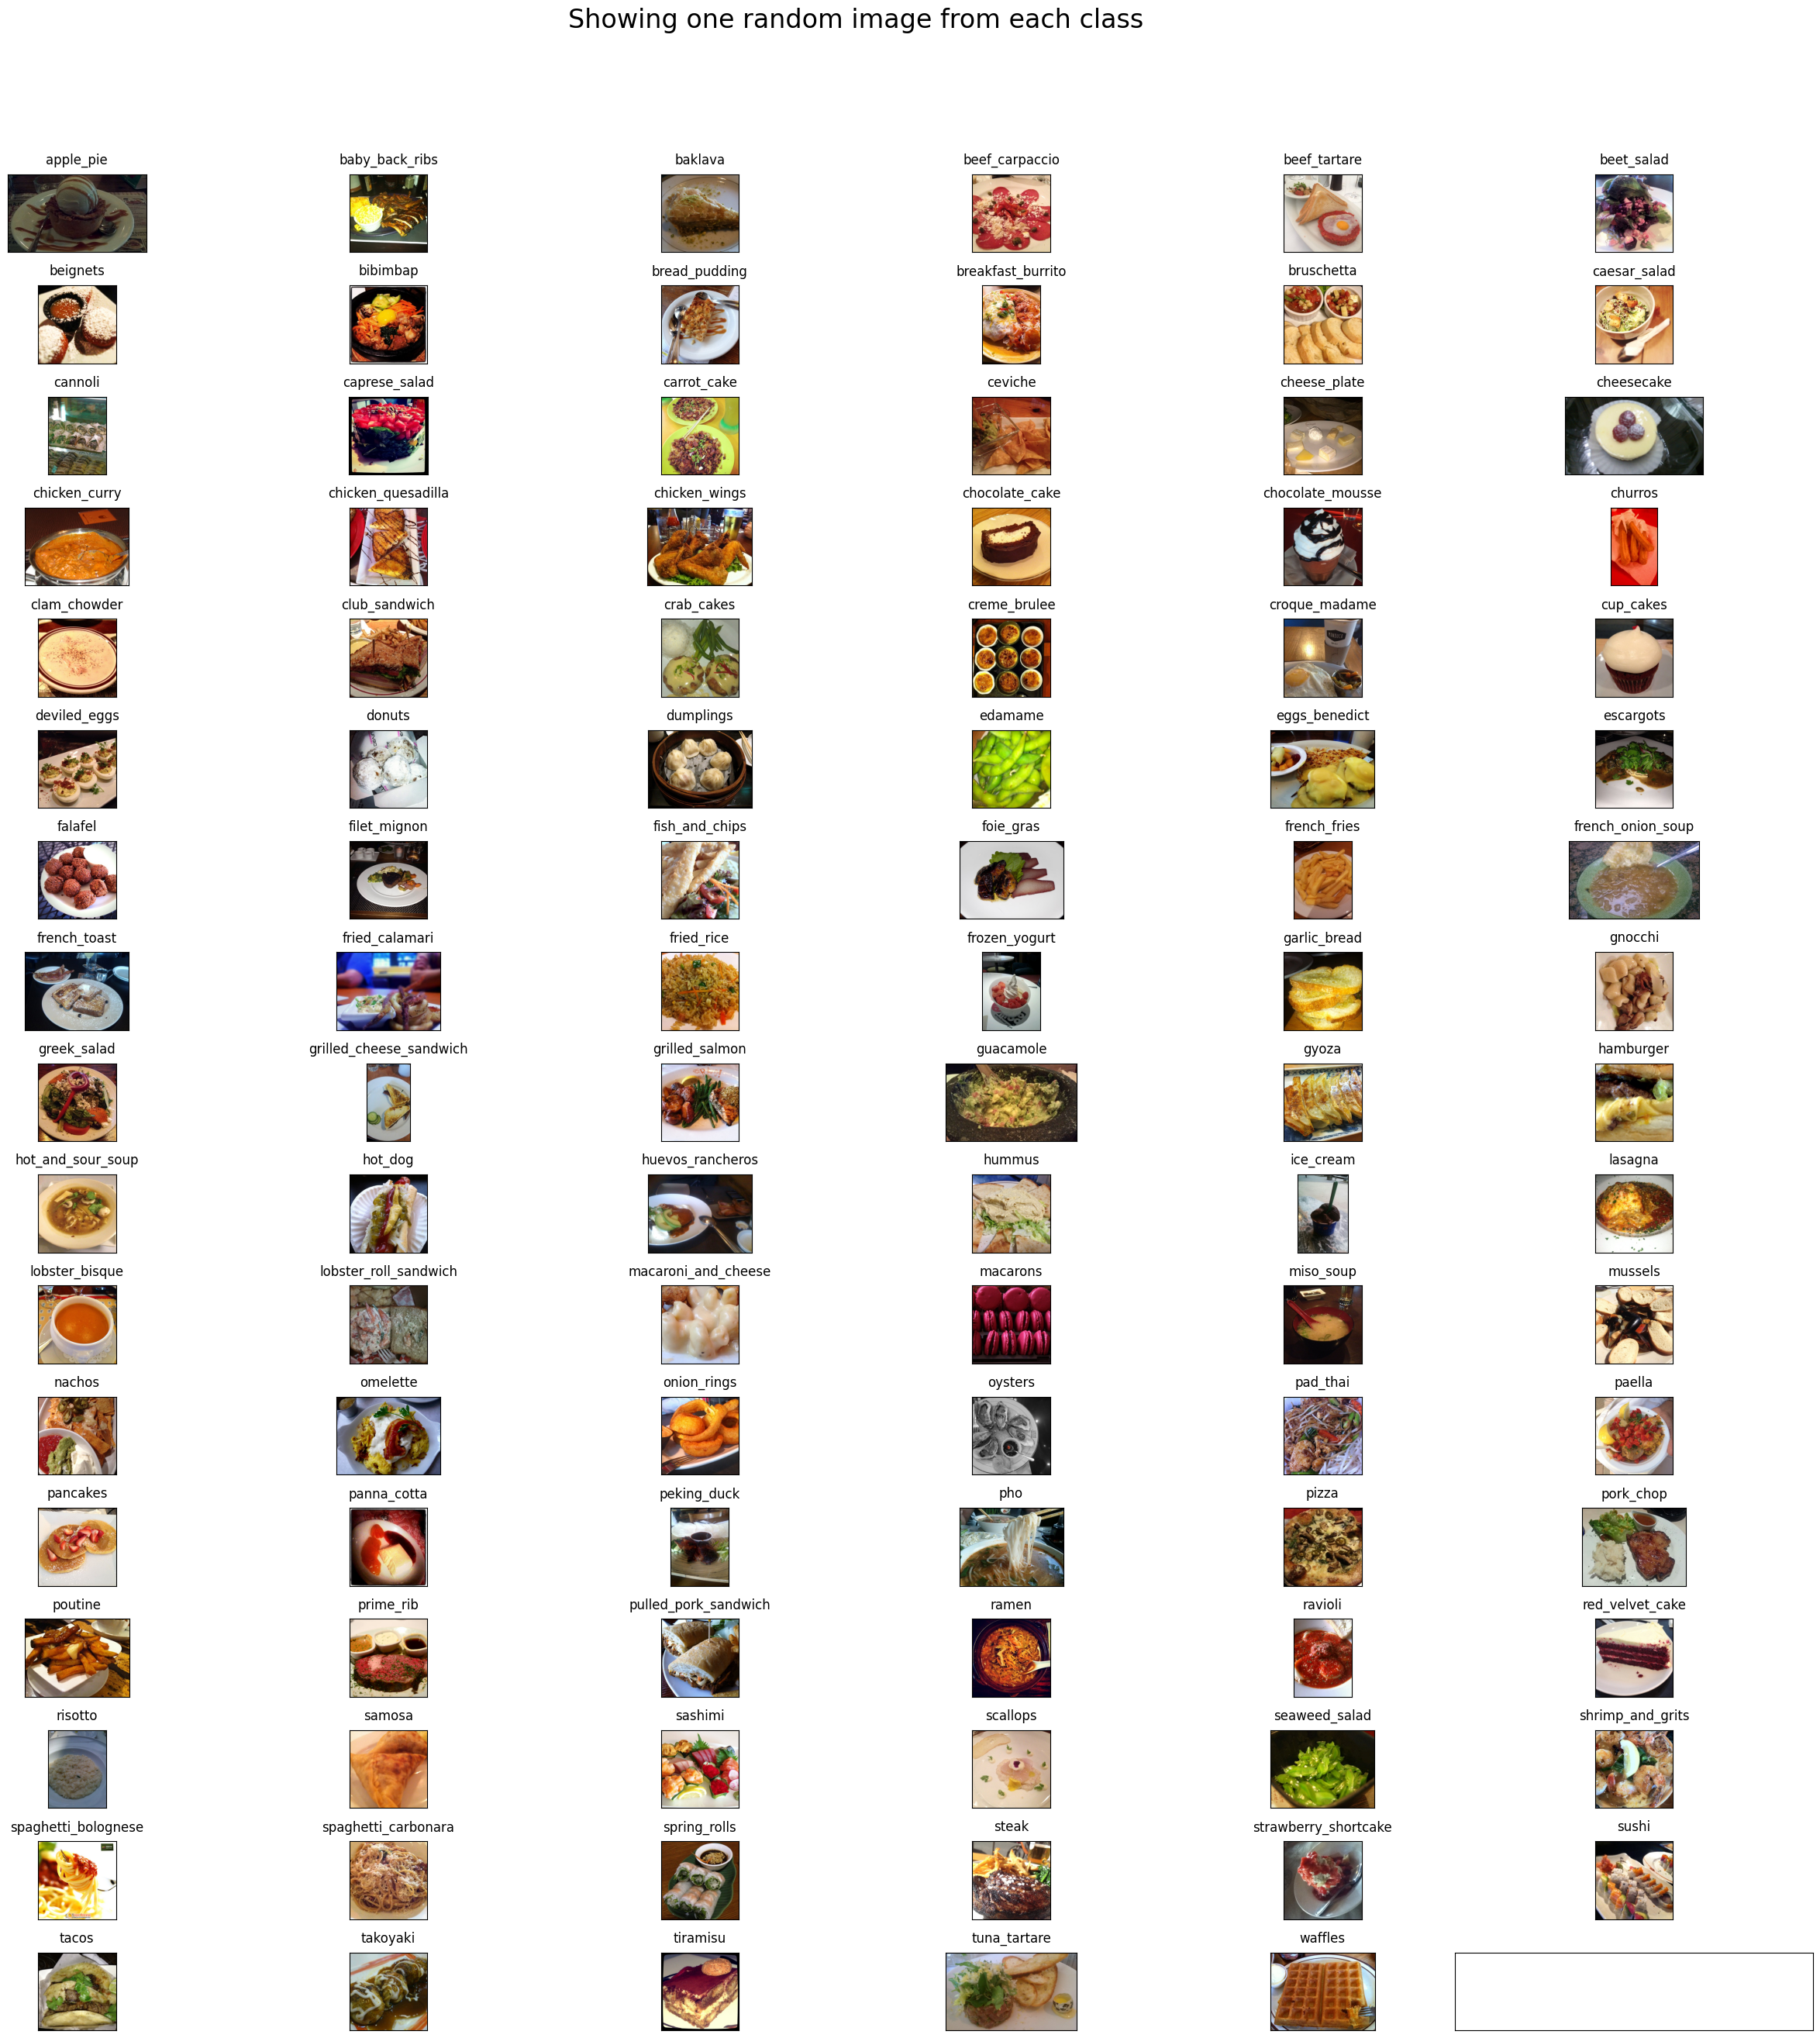

In [4]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [5]:
import os

# Ruta de la carpeta en Google Drive
carpeta_modelos = '/content/drive/MyDrive/modelos'

# Crear la carpeta
if not os.path.exists(carpeta_modelos):
    os.makedirs(carpeta_modelos)
    print("Carpeta 'modelos' creada en Google Drive.")
else:
    print("La carpeta 'modelos' ya existe.")


La carpeta 'modelos' ya existe.


In [6]:
import os
import shutil

def create_directories(base_dir):
    """Crea carpetas para cada clase dentro del dataset."""
    with open(os.path.join(base_dir, 'meta', 'classes.txt'), 'r') as f:
        classes = [line.strip() for line in f]
        for category in classes:
            os.makedirs(os.path.join(base_dir, 'train', category), exist_ok=True)
            os.makedirs(os.path.join(base_dir, 'test', category), exist_ok=True)

def copy_images(txt_file, src_dir, dst_dir):
    """Copia imágenes desde src_dir al dst_dir según el archivo txt."""
    with open(txt_file, 'r') as f:
        for line in f:
            image_path = line.strip() + '.jpg'
            category = image_path.split('/')[0]

            src_path = os.path.join(src_dir, image_path)
            dst_path = os.path.join(dst_dir, category, os.path.basename(image_path))
            shutil.copy(src_path, dst_path)

def prepare_dataset():
    """Prepara los datasets completos de train y test."""
    base_dir = 'food-101'
    images_dir = os.path.join(base_dir, 'images')

    # Crear las carpetas de salida para todas las clases
    create_directories(base_dir)

    # Copiar las imágenes según los archivos txt
    print("Preparando train...")
    copy_images(os.path.join(base_dir, 'meta', 'train.txt'), images_dir, os.path.join(base_dir, 'train'))

    print("Preparando test...")
    copy_images(os.path.join(base_dir, 'meta', 'test.txt'), images_dir, os.path.join(base_dir, 'test'))

    print("Proceso completado.")

# Descargar y preparar el dataset
get_data_extract()
prepare_dataset()


Dataset already exists
Preparando train...
Preparando test...
Proceso completado.


In [7]:
import os

train_dir = 'food-101/train'
test_dir = 'food-101/test'

train_count = sum([len(files) for r, d, files in os.walk(train_dir)])
test_count = sum([len(files) for r, d, files in os.walk(test_dir)])

print(f"Cantidad de imágenes en train: {train_count}")
print(f"Cantidad de imágenes en test: {test_count}")

Cantidad de imágenes en train: 75750
Cantidad de imágenes en test: 25250


In [15]:
def dataset_mini(food_list, src, dest):
    """Crea datasets mini con solo las clases seleccionadas."""
    if os.path.exists(dest):
        rmtree(dest)  # Eliminar dataset_mini si ya existe para evitar duplicados
    os.makedirs(dest, exist_ok=True)

    for food_item in food_list:
        src_path = os.path.join(src, food_item)
        dest_path = os.path.join(dest, food_item)

        print(f"Copiando imágenes de {food_item}...")
        copytree(src_path, dest_path)  # Copia todas las imágenes de la clase

# Definir las clases específicas para los subsets mini
food_list = ['french_fries', 'pizza', 'cup_cakes', 'frozen_yogurt', 'hamburger', 'sushi', 'pancakes', 'ramen']

# Definir las rutas de los conjuntos de datos completos y mini
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

# Crear los datasets mini para train y test
print("Creando el dataset train_mini con las nuevas clases...")
dataset_mini(food_list, src_train, dest_train)

print("Creando el dataset test_mini con las nuevas clases...")
dataset_mini(food_list, src_test, dest_test)

print("Proceso completado.")

Creando el dataset train_mini con las nuevas clases...
Copiando imágenes de french_fries...
Copiando imágenes de pizza...
Copiando imágenes de cup_cakes...
Copiando imágenes de frozen_yogurt...
Copiando imágenes de hamburger...
Copiando imágenes de sushi...
Copiando imágenes de pancakes...
Copiando imágenes de ramen...
Creando el dataset test_mini con las nuevas clases...
Copiando imágenes de french_fries...
Copiando imágenes de pizza...
Copiando imágenes de cup_cakes...
Copiando imágenes de frozen_yogurt...
Copiando imágenes de hamburger...
Copiando imágenes de sushi...
Copiando imágenes de pancakes...
Copiando imágenes de ramen...
Proceso completado.


In [16]:
train_mini_dir = 'food-101/train_mini'
test_mini_dir = 'food-101/test_mini'

train_mini_count = sum([len(files) for r, d, files in os.walk(train_mini_dir)])
test_mini_count = sum([len(files) for r, d, files in os.walk(test_mini_dir)])

print(f"Cantidad de imágenes en train_mini: {train_mini_count}")
print(f"Cantidad de imágenes en test_mini: {test_mini_count}")

Cantidad de imágenes en train_mini: 6000
Cantidad de imágenes en test_mini: 2000


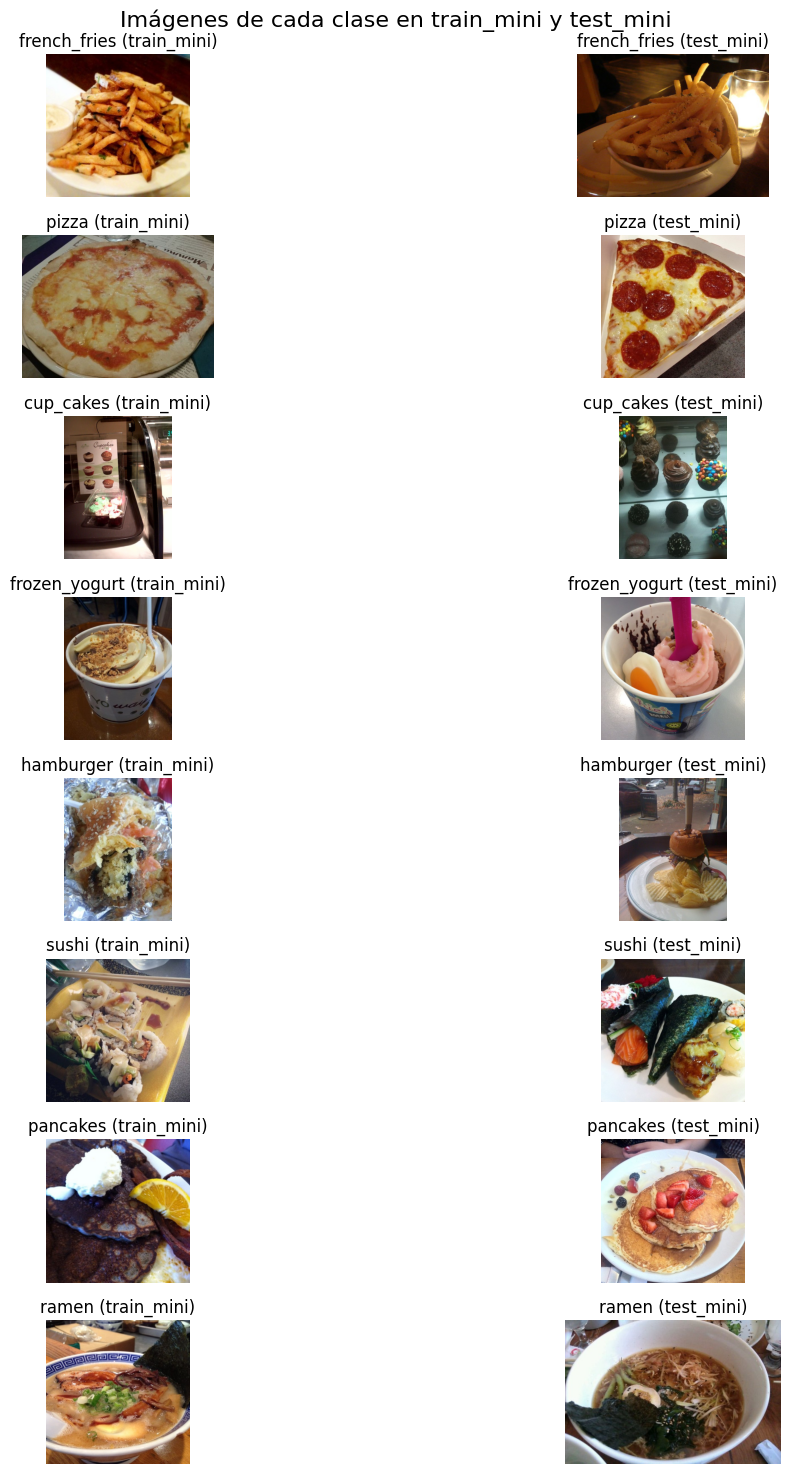

In [17]:
train_mini_dir = 'food-101/train_mini'
test_mini_dir = 'food-101/test_mini'

rows = 8
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(15, 15))
fig.suptitle("Imágenes de cada clase en train_mini y test_mini", fontsize=16)

for i, food_class in enumerate(['french_fries', 'pizza', 'cup_cakes', 'frozen_yogurt', 'hamburger', 'sushi', 'pancakes', 'ramen']):
  # Visualizar train_mini
  train_class_dir = os.path.join(train_mini_dir, food_class)
  train_images = os.listdir(train_class_dir)
  if train_images:
    train_image_path = os.path.join(train_class_dir, random.choice(train_images))
    img = plt.imread(train_image_path)
    ax[i][0].imshow(img)
    ax[i][0].set_title(f"{food_class} (train_mini)")
    ax[i][0].axis('off')

  # Visualizar test_mini
  test_class_dir = os.path.join(test_mini_dir, food_class)
  test_images = os.listdir(test_class_dir)
  if test_images:
    test_image_path = os.path.join(test_class_dir, random.choice(test_images))
    img = plt.imread(test_image_path)
    ax[i][1].imshow(img)
    ax[i][1].set_title(f"{food_class} (test_mini)")
    ax[i][1].axis('off')


plt.tight_layout()
plt.show()

In [19]:
# Rutas locales de las carpetas train_mini y test_mini
local_train_mini = 'food-101/train_mini'
local_test_mini = 'food-101/test_mini'

# Rutas de destino en Google Drive
drive_train_mini = '/content/drive/MyDrive/modelos/food-101/train_mini'
drive_test_mini = '/content/drive/MyDrive/modelos/food-101/test_mini'

# Función para mover los archivos
def move_files(src_dir, dest_dir):
    """Mueve archivos de src_dir a dest_dir conservando las subcarpetas."""
    for root, _, files in os.walk(src_dir):
        for file in files:
            src_file = os.path.join(root, file)
            # Obtener la subcarpeta relativa para replicarla en Drive
            relative_path = os.path.relpath(root, src_dir)
            dest_subdir = os.path.join(dest_dir, relative_path)
            # Crear subcarpeta si no existe
            os.makedirs(dest_subdir, exist_ok=True)
            # Mover archivo
            dest_file = os.path.join(dest_subdir, file)
            shutil.move(src_file, dest_file)
            print(f"Movido: {src_file} -> {dest_file}")

# Mover archivos de train_mini y test_mini a Google Drive
print("Moviendo archivos de train_mini a Google Drive...")
move_files(local_train_mini, drive_train_mini)

print("Moviendo archivos de test_mini a Google Drive...")
move_files(local_test_mini, drive_test_mini)

print("Proceso completado.")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Movido: food-101/train_mini/frozen_yogurt/3285065.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/3285065.jpg
Movido: food-101/train_mini/frozen_yogurt/1907489.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/1907489.jpg
Movido: food-101/train_mini/frozen_yogurt/11003.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/11003.jpg
Movido: food-101/train_mini/frozen_yogurt/2436299.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/2436299.jpg
Movido: food-101/train_mini/frozen_yogurt/1777731.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/1777731.jpg
Movido: food-101/train_mini/frozen_yogurt/563979.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/563979.jpg
Movido: food-101/train_mini/frozen_yogurt/37792.jpg -> /content/drive/MyDrive/modelos/food-101/train_mini/frozen_yogurt/37792.jpg
Movid

In [ ]:
# Rutas en Google Drive
base_dir = '/content/drive/MyDrive/modelos/food-101'
train_dir = os.path.join(base_dir, 'train_mini')
test_dir = os.path.join(base_dir, 'test_mini')

# Helper para crear los datasets mini
def dataset_mini(food_list, src, dest):
    if os.path.exists(dest):
        rmtree(dest)  # Elimina el destino si ya existe
    os.makedirs(dest, exist_ok=True)

    for food_item in food_list:
        src_path = os.path.join(src, food_item)
        dest_path = os.path.join(dest, food_item)
        print(f"Copiando imágenes de {food_item}...")
        copytree(src_path, dest_path)

# Definir las clases específicas
food_list = ['french_fries', 'pizza', 'cup_cakes']

# Crear los datasets mini
print("Creando train_mini...")
dataset_mini(food_list, '/content/food-101/train', train_dir)

print("Creando test_mini...")
dataset_mini(food_list, '/content/food-101/test', test_dir)

# Generadores de datos
img_size = (299, 299)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Cargar el modelo base InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


Creando train_mini...
Copiando imágenes de french_fries...
Copiando imágenes de pizza...
Copiando imágenes de cup_cakes...
Creando test_mini...
Copiando imágenes de french_fries...
Copiando imágenes de pizza...
Copiando imágenes de cup_cakes...
Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


## Modelo 1


In [ ]:
K.clear_session()

n_classes = 3
img_width, img_height = 224, 224
train_data_dir = '/content/drive/MyDrive/modelos/food-101/train_mini'
validation_data_dir = '/content/drive/MyDrive/modelos/food-101/test_mini'
nb_train_samples = 2250  # Total de imágenes de entrenamiento
nb_validation_samples = 750  # Total de imágenes de validación
batch_size = 32

# Generadores de datos con aumentación para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generadores para cargar los datos desde los directorios
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Cargar el modelo MobileNetV2 sin la capa superior
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para nuestra tarea
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Rutas para guardar los archivos en Google Drive
best_model_path = '/content/drive/MyDrive/modelos/best_model_mobilenet.keras'
history_log_path = '/content/drive/MyDrive/modelos/history_mobilenet.log'
final_model_path = '/content/drive/MyDrive/modelos/model_trained_mobilenet.keras'

# Callbacks para guardar el mejor modelo y registrar el historial
checkpointer = ModelCheckpoint(filepath=best_model_path, verbose=1, save_best_only=True)
csv_logger = CSVLogger(history_log_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopping]
)

# Guardar el modelo final
print(f"Guardando el modelo final en {final_model_path}...")
model.save(final_model_path)

print("Entrenamiento completado y modelo guardado.")


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5401 - loss: 1.0327
Epoch 1: val_loss improved from inf to 0.15255, saving model to /content/drive/MyDrive/modelos/best_model_mobilenet.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 59s 637ms/step - accuracy: 0.5427 - loss: 1.0276 - val_accuracy: 0.9715 - val_loss: 0.1525
Epoch 2/30
 1/70 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9375 - loss: 0.2093
Epoch 2: val_loss did not improve from 0.15255
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9375 - loss: 0.2093 - val_accuracy: 0.8571 - val_loss: 0.2117
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9285 - loss: 0.2431
Epoch 3: val_loss improved from 0.15255 to 0.08319, saving model to /content/drive/MyDrive/modelos/best_model_mobilenet.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 64s 516ms/step - accuracy: 0.9285 - loss: 0.2428 - val_

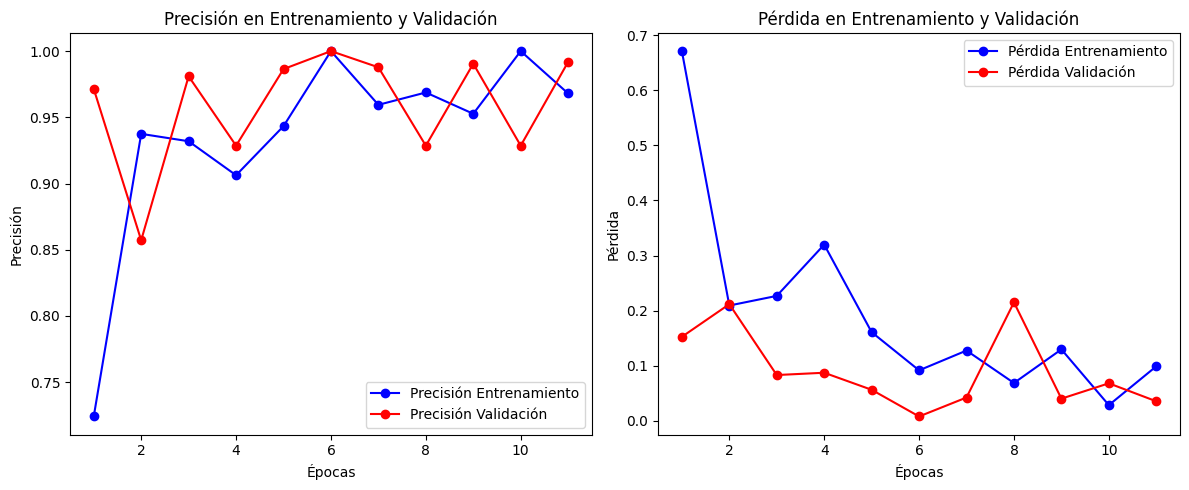

In [ ]:
# Gráfico de las métricas
plot_history(history)

## Modelo 2

In [32]:
import os
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

K.clear_session()

n_classes = 8
img_width, img_height = 299, 299
train_data_dir = '/content/drive/MyDrive/modelos/food-101/train_mini'
validation_data_dir = '/content/drive/MyDrive/modelos/food-101/test_mini'
nb_train_samples = 2250
nb_validation_samples = 750
batch_size = 32

# Verificar fuga de datos
train_files = set(os.listdir(train_data_dir))
validation_files = set(os.listdir(validation_data_dir))
intersection = train_files.intersection(validation_files)
if intersection:
    print(f"Archivos repetidos: {intersection}")
else:
    print("No hay archivos repetidos entre entrenamiento y validación.")

# Generadores de datos con aumentación avanzada
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generadores para cargar los datos desde las carpetas
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Revisar la distribución de clases
print("Distribución de clases en entrenamiento:", train_generator.class_indices)
print("Distribución de clases en validación:", validation_generator.class_indices)

# Cargar el modelo InceptionV3 preentrenado sin la capa superior
inception = InceptionV3(weights='imagenet', include_top=False)

# Añadir capas personalizadas
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout incrementado para mayor regularización

# Capa de salida con regularización L1 y L2
predictions = Dense(n_classes,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=inception.input, outputs=predictions)

# Compilar el modelo con optimizador Adam
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Rutas para guardar los archivos en Google Drive
best_model_path = '/content/drive/MyDrive/modelos/best_model_3class.keras'
history_log_path = '/content/drive/MyDrive/modelos/history_3class.log'
final_model_path = '/content/drive/MyDrive/modelos/model_trained_3class.keras'

# Callbacks para guardar el mejor modelo y registrar el historial
checkpointer = ModelCheckpoint(filepath=best_model_path, verbose=1, save_best_only=True)
csv_logger = CSVLogger(history_log_path)

# Añadir EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpointer, early_stopping]
)

# Guardar el modelo final
print(f"Guardando el modelo final en {final_model_path}...")
model.save(final_model_path)



Archivos repetidos: {'cup_cakes', 'ramen', 'hamburger', 'frozen_yogurt', 'french_fries', 'sushi', 'pancakes', 'pizza'}
Found 6000 images belonging to 8 classes.
Found 2000 images belonging to 8 classes.
Distribución de clases en entrenamiento: {'cup_cakes': 0, 'french_fries': 1, 'frozen_yogurt': 2, 'hamburger': 3, 'pancakes': 4, 'pizza': 5, 'ramen': 6, 'sushi': 7}
Distribución de clases en validación: {'cup_cakes': 0, 'french_fries': 1, 'frozen_yogurt': 2, 'hamburger': 3, 'pancakes': 4, 'pizza': 5, 'ramen': 6, 'sushi': 7}
Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4391 - loss: 1.5687
Epoch 1: val_loss improved from inf to 0.28157, saving model to /content/drive/MyDrive/modelos/best_model_3class.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.4417 - loss: 1.5622 - val_accuracy: 0.9117 - val_loss: 0.2816
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8477 - loss: 0.5001
Epoch 2: val_loss improved from 0.28157 to 0.23048, saving model to 

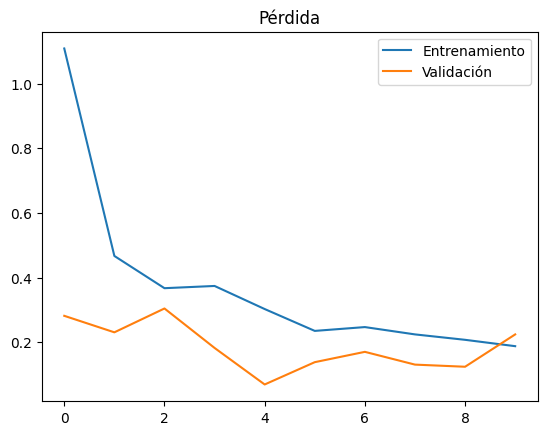

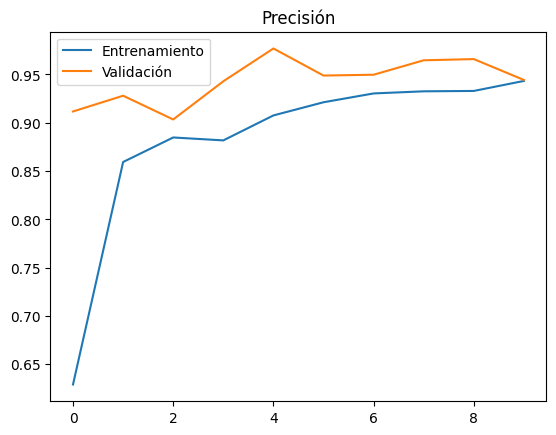

In [33]:
# Graficar métricas

def plot_metrics(history):
    # Graficar pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.legend()
    plt.show()

    # Graficar precisión
    plt.figure()
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.legend()
    plt.show()

plot_metrics(history)


In [34]:
# Revisar los índices de las clases
print(train_generator.class_indices)

{'cup_cakes': 0, 'french_fries': 1, 'frozen_yogurt': 2, 'hamburger': 3, 'pancakes': 4, 'pizza': 5, 'ramen': 6, 'sushi': 7}


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
URL: https://newluxbrand.com/wp-content/uploads/2022/01/pizza-jamo%CC%81n-y-queso-Newlux-1536x1536-optimized.jpg
Predicción: [5]
Probabilidades por clase: [[0.22394828 0.07443669 0.08226652 0.03220663 0.10611674 0.25935012
  0.08178774 0.13988724]]


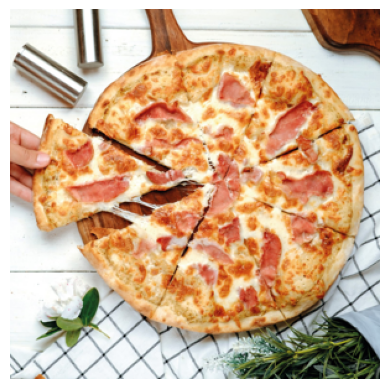

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
URL: https://laclass.cl/wp-content/uploads/2020/11/PapasGrandes.jpg
Predicción: [5]
Probabilidades por clase: [[0.0849312  0.09174631 0.05049973 0.04469712 0.10457703 0.49755546
  0.06561426 0.06037886]]


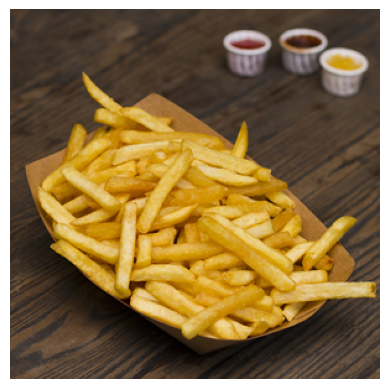

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
URL: https://media.foodspring.com/magazine/public/uploads/2022/03/March-2022-foodspring-205.jpg
Predicción: [5]
Probabilidades por clase: [[0.10278788 0.11657137 0.06691846 0.05268665 0.12699927 0.3819215
  0.07726902 0.07484579]]


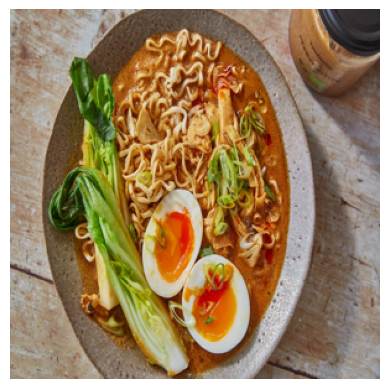

In [10]:
# Importar las bibliotecas necesarias
import tensorflow as tf
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Ruta al modelo guardado
model_path = '/content/drive/MyDrive/modelos/model_trained_3class.keras'
model = tf.keras.models.load_model(model_path)

# Lista de URLs de imágenes de prueba
img_urls = [
    'https://newluxbrand.com/wp-content/uploads/2022/01/pizza-jamo%CC%81n-y-queso-Newlux-1536x1536-optimized.jpg',
    'https://laclass.cl/wp-content/uploads/2020/11/PapasGrandes.jpg',
    'https://media.foodspring.com/magazine/public/uploads/2022/03/March-2022-foodspring-205.jpg'
]

# Función para preprocesar la imagen
def preprocess_image(url):
    """Descarga y preprocesa una imagen desde la URL."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((299, 299))  # Redimensionar a 299x299
    img_array = img_to_array(img)  # Convertir a array de NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Añadir dimensión para el batch
    img_array = preprocess_input(img_array)  # Preprocesar para InceptionV3
    return img, img_array

# Función para mostrar la imagen y su predicción
def predict_and_show(url):
    """Realiza la predicción y muestra la imagen junto con su clase predicha."""
    img, img_array = preprocess_image(url)  # Preprocesar la imagen
    predictions = model.predict(img_array)  # Realizar predicción
    predicted_class = np.argmax(predictions, axis=1)  # Clase con mayor probabilidad

    # Mostrar los resultados
    print(f"URL: {url}")
    print(f"Predicción: {predicted_class}")
    print(f"Probabilidades por clase: {predictions}")

    # Visualizar la imagen
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Probar todas las imágenes de la lista
for url in img_urls:
    predict_and_show(url)


## Limitaciones del modelo

- Gran costo computacional a la hora de hacer un entrenamiento con todas las clases.
- Imágenes intencionalmente no depuradas, lo que puede dificultar el aprendizaje del modelo.
- Los mini dataset pudieron no ser suficiente para un entrenamiento óptimo del modelo.
- Los modelos utilizado están diseñados para grandes volúmenes de datos y esto pudo conllevar al overfitting.

## Conclusiones

El último modelo entrenado fue corregido para mejorar sus hiperparámetros y lograr una clasificación precisa de las imágenes. Sin embargo, es notable un overfitting de los datos, redirigiendo su predicción hacia la pizza, no logrando una adecuada clasificación de estas imágenes.

Aun así, es posible mejorar la precisión del modelo entrenándolo en una máquina con mayor capacidad de procesamiento. También es recomendable utilizar mini datasets con una mayor diversidad de clases y aplicar técnicas adicionales de aumentación de datos para enriquecer el aprendizaje. En una segunda fase, estas mejoras permitirán desarrollar un modelo más preciso para la clasificación de imágenes de comida.
